In [3]:
import sys
import numpy as np
import rescomp as rc
import rescomp.optimizer as rcopt
from ipyparallel import Client
import types
from matplotlib import pyplot as plt
import pandas as pd

In [4]:
def copy_local_variables(dview, local, *args):
    """Copies variables over. locals() should be passed as the value of local (which is kind of a hack but w/e).
    Will not try to push modules (because ipyparallel throws an error if you try)"""
    local_vars = {name:local[name] for name in args if not isinstance(local[name], types.ModuleType)}
    dview.push(local_vars, block=True)

def import_remote(dview, **kwargs):
    """Allows importing lots of modules on all the remote engines.
    Can execute arbitrary code so don't run on unsanitized input, if that happens to be relevant."""
    for key in kwargs:
        if kwargs[key] is None:
            string = "import {}".format(key)
        else:
            string = "from {} import {}".format(key,kwargs[key])
    dview.execute(string, block=True)
    

In [5]:
def covariance(A, unbiased=True):
    """
    Computes the covariance matrix of A, where A[k,:] is the kth data point.
    unbiased=True uses the unbiased estimator, False uses the MLE
    """
    m = A.shape[0]
    if unbiased:
        m = m - 1
    Acentered = (A - np.mean(A,axis=0)) #/ np.sqrt(m)
    return np.einsum('ab,ac->bc', Acentered,Acentered) / m
    
def compute_correlation_measure(A):
    """
    Computes the sum of the squares of the correlation coefficients of the coordinates of A with each other.
    """
    m,n = A.shape
    A_cov = covariance(A)
    A_var = np.diag(A_cov)
    scaled = (A_cov**2 / A_var.reshape(1,-1))/A_var.reshape(-1,1)
    scaled[np.isnan(scaled)] = 0
    
    def _n2(k):
        return (k**2+k)/2
    #Count all intersections of 0-variance values as 1, then average. Should be in [0,1], may be slightly larger due to rounding error
    return ((np.sum(scaled)-n)/2 + _n2(np.sum(np.abs(A_var)<1e-9)))/_n2(n)

def compute_correlation_vector(A):
    m,n = A.shape
    A_cov = covariance(A)
    A_var = np.diag(A_cov)
    scaled = (A_cov**2 / A_var.reshape(1,-1))/A_var.reshape(-1,1)
    nan = np.any(np.isnan(scaled),axis=0)
    scaled[nan,:] = 0
    scaled[:,nan] = 0
    scaled[nan,nan] = 1
    return np.mean(scaled, axis=0)
    
def second_correlation_measure(corrvect, Wout):
    weighted_corr = np.abs(Wout) @ corrvect
    weights = np.sum(np.abs(Wout), axis=1)
    corr = weighted_corr / weights
    print(corr)
    return np.max(corr)
    
####Overwriting rescomp functions####
def update_tikhanov_factors(self, t, U):
    """ 
    Version of the function to store the correlation measure
    Drive the reservoir with the u and collect state information into
        self.Rhat and self.Yhat
        Parameters
        t (1 dim array): array of time values
        U (array): for each i, U[i, :] produces the state of the target system
            at time t[i]
    """
    # The i + batchsize + 1 ending adds one timestep of overlap to provide
    # the initial condition for the next batch. Overlap is removed after
    # the internal states are generated
    idxs = [(i, i + self.batchsize + 1) for i in range(0, len(t), self.batchsize)]
    #Prevent length-1 segment at the end
    if len(t)-idxs[-1][0] <= 1:
        idxs = idxs[:-1]
        idxs[-1] = (idxs[-1][0], len(t))
    # Set initial condition for reservoir nodes
    r0 = self.initial_condition(U[0, :])
    for start, end in idxs:
        ti = t[start:end]
        Ui = U[start:end, :]
        states = self.internal_state_response(ti, Ui, r0)
        # Get next initial condition and trim overlap
        states, r0 = states[:-1, :], states[-1, :]
        # Update Rhat and Yhat
        self.Rhat += states.T @ states
        self.Yhat += Ui[:-1, :].T @ states
        corr = compute_correlation_vector(states)
        self.correlation += corr
        #print(corr)
        self.correlation_count += 1
    self.r0 = r0
    
def train(self, t, U, window=None, overlap=0):
    """ Train the reservoir computer so that it can replicate the data in U.

        Paramters
        ---------
        t (1-d array or list of 1-d arrays): Array of m equally spaced time values corresponding to signal U.
        U (array or list of arrays): Input signal array (m x self.signal_dim) where the ith row corresponds to the
            signal value at time t[i]
        window (float): If window is not `None` the reservoir computer will subdivide the input signal
            into blocks where each block corresponds to `window` seconds of time.
            Defaults to None
        overlap (float): Must be less than one and greater or equal to zero. If greater than zero, this
            will cause subdivided input signal blocks to overlap. The `overlap` variable specifies the
            percent that each signal window overlaps the previous signal window
            Defaults to 0.0
    """
    self.correlation = np.zeros(self.res_sz)
    self.correlation_count = 0
    if isinstance(U, list) and isinstance(t, list):
        for time, signal in zip(t, U):
            idxs = self._partition(time, window, overlap=overlap)
            for start, end in idxs:
                ti = time[start:end]
                Ui = signal[start:end, :]
                self.update_tikhanov_factors(ti, Ui)
    else:
        idxs = self._partition(t, window, overlap=overlap)
        for start, end in idxs:
            ti = t[start:end]
            Ui = U[start:end, :]
            self.update_tikhanov_factors(ti, Ui)
    self.W_out = self.solve_wout()
    self.is_trained = True
    self.correlation = self.correlation / self.correlation_count
    #print(self.correlation)



In [5]:
A = np.random.random((80,20))

compute_correlation_vector(A)

array([0.06136905, 0.06130636, 0.06243796, 0.06565578, 0.06131127,
       0.05845994, 0.05947356, 0.06096903, 0.06582711, 0.06198271,
       0.06366896, 0.06535057, 0.06277786, 0.06853048, 0.0652656 ,
       0.06361713, 0.06540178, 0.05798207, 0.0647349 , 0.05894968])

In [16]:
optimizer = rcopt.ResCompOptimizer('lorenz','activ_f','random','augmented')
parameters = {'sigma': 2.518182559401357,
             'gamma': 5.790760655159745,
             'ridge_alpha': 0.0014066107907287084,
             'spect_rad': 19.64735209662313,
             'mean_degree': 5.0,
             'window': 0.6711954818252962,
             'overlap': 0.9,
             'res_sz': 100,
             'update_tikhanov_factors':update_tikhanov_factors,
             'train':train}

data_list = optimizer.generate_orbits(1, parameters, True)[0]

In [19]:
data_list[0].W_out.shape

(3, 100)

In [4]:
def main(n):
    optimizer = rcopt.ResCompOptimizer('lorenz','activ_f','random','augmented')
    parameters = {'sigma': 2.518182559401357,
                 'gamma': 5.790760655159745,
                 'ridge_alpha': 0.0014066107907287084,
                 'spect_rad': 19.64735209662313,
                 'mean_degree': 5.0,
                 'window': 0.6711954818252962,
                 'overlap': 0.9,
                 'update_tikhanov_factors':update_tikhanov_factors,
                 'train':train}
    
    data_list = optimizer.generate_orbits(n, parameters, True)
    
    results_list = [(rcopt.get_vptime(optimizer.system, ts, Uts, pre),
                     second_correlation_measure(rcomp.correlation, rcomp.W_out))
                    for rcomp, tr, Utr, ts, Uts, pre in data_list]
           
    return results_list


In [32]:
exit()
client = Client()
dview = client[:]
import_remote(dview, **{'numpy as np':None, 'rescomp.optimizer as rcopt':None})

dview.execute('import numpy as np', block=True)

copy_local_variables(dview, locals(),'covariance','compute_correlation_measure', 'compute_correlation_vector',
                    'second_correlation_measure', 'update_tikhanov_factors', 'train')
results=dview.apply_sync(main, 25)
print("Finished!")

Finished!


In [41]:
results_all = [item for L in results for item in L]
corrs = [item[1] for item in results_all]
vpts = [item[0] for item in results_all]

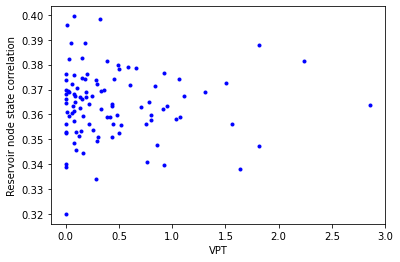

In [42]:
plt.plot(vpts,corrs,'b.')
plt.xlabel('VPT')
plt.ylabel("Reservoir node state correlation")
plt.show()

In [1]:
def main2(n):
    optimizer = rcopt.ResCompOptimizer('lorenz','activ_f','continue','standard')
    parameters = {'sigma': 0.01,
                 'gamma': 25.0,
                 'ridge_alpha': 1e-08,
                 'spect_rad': 4.060882064610251,
                 'mean_degree': 2.079117239034718,
                 'update_tikhanov_factors':update_tikhanov_factors,
                 'train':train}
    
    data_list = optimizer.generate_orbits(n, parameters, True)
    
    results_list = [(rcopt.get_vptime(optimizer.system, ts, Uts, pre),
                     second_correlation_measure(rcomp.correlation, rcomp.W_out))
                    for rcomp, tr, Utr, ts, Uts, pre in data_list]
           
    return results_list

In [8]:
exit()
client = Client()
dview = client[:]
import_remote(dview, **{'numpy as np':None, 'rescomp.optimizer as rcopt':None})

dview.execute('import numpy as np', block=True)

copy_local_variables(dview, locals(),'covariance','compute_correlation_measure', 'compute_correlation_vector',
                    'second_correlation_measure', 'update_tikhanov_factors', 'train')
results_continue=dview.apply_sync(main2, 15)
print("Finished!")

Finished!


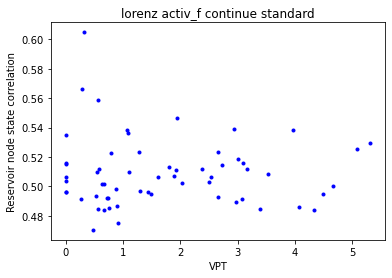

In [9]:
results_all = [item for L in results_continue for item in L]
corrs = [item[1] for item in results_all]
vpts = [item[0] for item in results_all]
plt.plot(vpts,corrs,'b.')
plt.xlabel('VPT')
plt.ylabel("Reservoir node state correlation")
plt.title("lorenz activ_f continue standard")
plt.show()

# lots of data time

In [33]:
class ResComp2(rc.ResComp):
    def __init__(self, edge_remove_p=0.0, **kwargs):
        #Set edge removal probability
        self.edge_remove_p = edge_remove_p
        super().__init__(**kwargs)
        
        #Initialize some other things
        self.tr_wout_r_corr = np.zeros(self.res_sz)
        self.tr_win_u_corr = 0
        self.res_correlation_count = 0
    
    def set_res_data_members(self):
        #Find how many to remove
        rm_count = int(self.edge_remove_p * np.sum(self.res > 0))
        self.res = ResComp2.remove_edges(self.res, rm_count)
        super().set_res_data_members()
    
    #Utility function from https://github.com/djpasseyjr/ChaosReservoir/blob/master/HyperParameterOpt/GenerateExperiments/res_experiment.py
    def remove_edges(A,nedges):
        """ Randomly removes 'nedges' edges from a sparse matrix 'A'
        """
        A = A.todok()
        # Remove Edges
        keys = list(A.keys())
        remove_idx = np.random.choice(range(len(keys)),size=nedges, replace=False)
        remove = [keys[i] for i in remove_idx]
        for e in remove:
            A[e] = 0
        return A.tolil()

    ####Overwriting rescomp functions####
    def update_tikhanov_factors(self, t, U):
        """ 
        Version of the function to store the correlation measure
        Drive the reservoir with the u and collect state information into
            self.Rhat and self.Yhat
            Parameters
            t (1 dim array): array of time values
            U (array): for each i, U[i, :] produces the state of the target system
                at time t[i]
        """
        # The i + batchsize + 1 ending adds one timestep of overlap to provide
        # the initial condition for the next batch. Overlap is removed after
        # the internal states are generated
        idxs = [(i, i + self.batchsize + 1) for i in range(0, len(t), self.batchsize)]
        #Prevent length-1 segment at the end
        if len(t)-idxs[-1][0] <= 1:
            idxs = idxs[:-1]
            idxs[-1] = (idxs[-1][0], len(t))
        # Set initial condition for reservoir nodes
        r0 = self.initial_condition(U[0, :])
        for start, end in idxs:
            ti = t[start:end]
            Ui = U[start:end, :]
            states = self.internal_state_response(ti, Ui, r0)
            # Get next initial condition and trim overlap
            states, r0 = states[:-1, :], states[-1, :]
            # Update Rhat and Yhat
            self.Rhat += states.T @ states
            self.Yhat += Ui[:-1, :].T @ states
            #Compute correlation measures
            res_corr = compute_correlation_vector(states)
            self.tr_wout_r_corr += res_corr
            input_corr = compute_correlation_vector(self.activ_f(Ui @ self.W_in.T))
            self.tr_win_u_corr += input_corr
            self.res_correlation_count += 1
        self.r0 = r0

    def train(self, t, U, window=None, overlap=0):
        """ Train the reservoir computer so that it can replicate the data in U.

            Paramters
            ---------
            t (1-d array or list of 1-d arrays): Array of m equally spaced time values corresponding to signal U.
            U (array or list of arrays): Input signal array (m x self.signal_dim) where the ith row corresponds to the
                signal value at time t[i]
            window (float): If window is not `None` the reservoir computer will subdivide the input signal
                into blocks where each block corresponds to `window` seconds of time.
                Defaults to None
            overlap (float): Must be less than one and greater or equal to zero. If greater than zero, this
                will cause subdivided input signal blocks to overlap. The `overlap` variable specifies the
                percent that each signal window overlaps the previous signal window
                Defaults to 0.0
        """

        if isinstance(U, list) and isinstance(t, list):
            for time, signal in zip(t, U):
                idxs = self._partition(time, window, overlap=overlap)
                for start, end in idxs:
                    ti = time[start:end]
                    Ui = signal[start:end, :]
                    self.update_tikhanov_factors(ti, Ui)
        else:
            idxs = self._partition(t, window, overlap=overlap)
            for start, end in idxs:
                ti = t[start:end]
                Ui = U[start:end, :]
                self.update_tikhanov_factors(ti, Ui)
        self.W_out = self.solve_wout()
        self.is_trained = True
        self.tr_wout_r_corr = self.tr_wout_r_corr / self.res_correlation_count
        self.tr_win_u_corr = self.tr_win_u_corr / self.res_correlation_count
        #print(self.correlation)



## Main thing

In [26]:
def generate_rescomps(run_ct, *exp_type, **params):
    """Generate run_ct reservoir computers with experiment exp_type and given parameters; returns various things"""
    optimizer = rcopt.ResCompOptimizer(*exp_type)
    data_list = optimizer.generate_orbits(run_ct, params, True)
    
    results_list = [(rcopt.get_vptime(optimizer.system, ts, Uts, pre),
                    rcomp.tr_win_u_corr,
                    rcomp.tr_wout_r_corr,
                    rcomp.W_out,
                    rcomp.W_in,
                    rcomp.res,)
                    for rcomp, tr, Utr, ts, Uts, pre in data_list]
    
    #Return as a DataFrame
    return pd.DataFrame(results_list, columns=['vpt', 'tr_win_u_corr', 'tr_wout_r_corr', 'W_out', 'W_in', 'res'])

In [38]:
#general outline
#client = Client()
#dview = client[:]

#run_ct = 50 // len(client.ids)
exp_type = ('lorenz','activ_f','continue','standard')
parameters = {'sigma': 0.01,
              'gamma': 25.0,
              'ridge_alpha': 1e-08,
              'spect_rad': 4.060882064610251,
              'mean_degree': 2.079117239034718,
              'edge_remove_p': 0.0,
              'res_sz': 500,
              'ResComp':ResComp2
    }


results_df = generate_rescomps(2, *exp_type, **parameters)
#results = pd.concat(
#        dview.apply_sync(generate_rescomps, run_ct, *exp_type, **params),
#        ignore_index = True
#    )
results_df

,vpt,tr_win_u_corr,tr_wout_r_corr,W_out,W_in,res
0,4.17,"[0.23677473866691642, 0.2362582926783008, 0.24...","[0.6762647570116037, 0.3601199786803135, 0.675...","[[0.28821372985839844, -0.6362323760986328, 0....","[[0.49112140534502746, 0.918784333150479, -0.4...","(0, 1)\t1.8714674205568798\n (0, 194)\t1.87..."
1,0.00,"[0.22251035209096515, 0.2800127302214702, 0.21...","[0.11244607329774764, 0.6651773659988587, 0.55...","[[-7.884120941162109, -1.5392522811889648, -2....","[[-0.9456771407414422, -0.9782139762215147, 0....","(0, 1)\t1.9268984055150822\n (1, 0)\t1.9268..."


In [45]:


W_in = results_df.loc[0, 'W_in']
win_u_corr = results_df.loc[0, 'tr_win_u_corr']

proj = np.abs(W_in).T @ win_u_corr
scaled = proj / np.sum(np.abs(W_in), axis=0)
scaled

array([0.22160399, 0.2252101 , 0.22052599])